# Imports

In [1]:
# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import time
import os

# Sklearn
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Tensorflow/Keras
import tensorflow as tf

# Load Data

In [2]:
# Load data
train_df = pd.read_csv("../processed_data/train_df.csv")
train_df['DATE_TIME']= pd.to_datetime(train_df['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')
train_df.DATE = pd.to_datetime(train_df.DATE,format='%Y-%m-%d')
# These were exported to train_df.csv
#train_df["HOUR"] = train_df['DATE_TIME'].dt.hour
#train_df.dropna(inplace=True)
#train_df.reset_index(drop=True, inplace=True)

test_df = pd.read_csv("../processed_data/test_df.csv")
test_df['DATE_TIME']= pd.to_datetime(test_df['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')
test_df.DATE = pd.to_datetime(test_df.DATE,format='%Y-%m-%d')
# These were exported to test_df.csv
#test_df["HOUR"] = test_df['DATE_TIME'].dt.hour
#test_df.dropna(inplace=True)
#test_df.reset_index(drop=True, inplace=True)


mae_results = {}
rmse_results = {}

train_df = train_df.dropna()
test_df = test_df.dropna()

In [3]:
### Add an additional feature to take into consideration the previous day's temperature inside the plant and near the
### panels
yesterdays_plant_train_temperature = []
yesterdays_panel_train_temperature = []
yesterdays_plant_train_temperature.append(0)
yesterdays_panel_train_temperature.append(0)
for i in range(len(train_df)-1):
    yesterdays_plant_train_temperature.append(train_df.iloc[i]["AMBIENT_TEMPERATURE"])
    yesterdays_panel_train_temperature.append(train_df.iloc[i]["MODULE_TEMPERATURE"])
train_df["yesterday_plant_temperature"] = yesterdays_plant_train_temperature
train_df["yesterday_panel_temperature"] = yesterdays_panel_train_temperature
train_df.head(10)

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,WEATHER_SOURCE,DATE,TIME,is_daytime,yesterday_max_daily_yield,yesterday_plant_temperature,yesterday_panel_temperature
4044,2020-05-16 01:45:00,4136001,LlT2YUhhzqhg5Sw,0.000000,0.000000,0.000000,2.826020e+08,25.954583,23.974197,0.000000,iq8k7ZNt4Mwm3w0,2020-05-16,01:45:00,0,9234.0,0.000000,0.000000
4045,2020-05-16 15:30:00,4136001,NgDl19wMapZy17u,582.106667,570.446667,7294.266667,1.115294e+08,34.537255,42.353539,0.393412,iq8k7ZNt4Mwm3w0,2020-05-16,15:30:00,1,9475.0,25.954583,23.974197
4046,2020-05-16 15:30:00,4136001,Mx2yZCDsyf6DPfv,597.557143,585.471429,5334.571429,2.466781e+06,34.537255,42.353539,0.393412,iq8k7ZNt4Mwm3w0,2020-05-16,15:30:00,1,7800.0,34.537255,42.353539
4047,2020-05-16 15:30:00,4136001,LlT2YUhhzqhg5Sw,547.846667,537.066667,7085.133333,2.826091e+08,34.537255,42.353539,0.393412,iq8k7ZNt4Mwm3w0,2020-05-16,15:30:00,1,9234.0,34.537255,42.353539
4048,2020-05-16 15:30:00,4136001,LYwnQax7tkwH5Cb,559.340000,548.213333,2717.400000,1.794970e+09,34.537255,42.353539,0.393412,iq8k7ZNt4Mwm3w0,2020-05-16,15:30:00,1,8458.0,34.537255,42.353539
4049,2020-05-16 15:30:00,4136001,IQ2d7wF4YD8zU1Q,596.246667,584.160000,7449.933333,1.995864e+07,34.537255,42.353539,0.393412,iq8k7ZNt4Mwm3w0,2020-05-16,15:30:00,1,9663.0,34.537255,42.353539
4050,2020-05-16 15:30:00,4136001,Et9kgGMDl729KT4,541.573333,530.853333,6062.133333,1.714466e+06,34.537255,42.353539,0.393412,iq8k7ZNt4Mwm3w0,2020-05-16,15:30:00,1,4154.0,34.537255,42.353539
4051,2020-05-16 15:30:00,4136001,9kRcWv60rDACzjR,574.500000,563.033333,7214.133333,2.247736e+09,34.537255,42.353539,0.393412,iq8k7ZNt4Mwm3w0,2020-05-16,15:30:00,1,9246.0,34.537255,42.353539
4052,2020-05-16 15:30:00,4136001,81aHJ1q11NBPMrL,573.766667,562.206667,4393.533333,1.215286e+09,34.537255,42.353539,0.393412,iq8k7ZNt4Mwm3w0,2020-05-16,15:30:00,1,3214.0,34.537255,42.353539
4053,2020-05-16 15:30:00,4136001,4UPUqMRk7TRMgml,613.285714,600.821429,5202.428571,2.438414e+06,34.537255,42.353539,0.393412,iq8k7ZNt4Mwm3w0,2020-05-16,15:30:00,1,9425.0,34.537255,42.353539


In [4]:
### Add an additional feature to take into consideration the previous day's temperature inside the plant and near the
### panels
yesterdays_plant_test_temperature = []
yesterdays_panel_test_temperature = []
yesterdays_plant_test_temperature.append(0)
yesterdays_panel_test_temperature.append(0)
for i in range(len(test_df)-1):
    yesterdays_plant_test_temperature.append(test_df.iloc[i]["AMBIENT_TEMPERATURE"])
    yesterdays_panel_test_temperature.append(test_df.iloc[i]["MODULE_TEMPERATURE"])
test_df["yesterday_plant_temperature"] = yesterdays_plant_test_temperature
test_df["yesterday_panel_temperature"] = yesterdays_panel_test_temperature

In [5]:
train_sunlight = train_df[train_df["is_daytime"] == 1]
test_sunlight = test_df[test_df["is_daytime"] == 1]

In [6]:
def calculate_metrics(label, true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae_results[label] = mae
    rmse_results[label] = rmse
    print(label + " MAE: " + str(mae) + " kW.")
    print(label + " RMSE: " + str(rmse) + " kW.")
    
def plot_true_vs_pred(label, true, pred):
    x_ax = range(len(true))
    plt.plot(x_ax, true, label="original")
    plt.plot(x_ax, pred, label="predicted")
    plt.title("Test and Predicted Data " + label)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show() 

## Linear Regression Model

In [7]:
### Features trained
lr_features = ["PLANT_ID", "TIME", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION", "is_daytime", "yesterday_max_daily_yield", "yesterday_plant_temperature"]

### Training Data
lr_training_data_x = train_df[lr_features]
lr_training_data_y = train_df.AC_POWER

# lr_training_data_x = train_sunlight[lr_features]
# lr_training_data_y = train_sunlight.AC_POWER

lr_training_data_x.PLANT_ID = lr_training_data_x.PLANT_ID.astype("category")
lr_training_data_x.is_daytime = lr_training_data_x.is_daytime.astype("category")
lr_training_data_x = pd.get_dummies(lr_training_data_x)

### Standardize Data
stndrd = preprocessing.StandardScaler()
stndrd.fit(lr_training_data_x)
lr_training_data_x = stndrd.transform(lr_training_data_x)

### Testing Data
lr_testing_data_x = test_df[lr_features]
lr_testing_data_y = test_df.AC_POWER

# lr_testing_data_x = test_sunlight[lr_features]
# lr_testing_data_y = test_sunlight.AC_POWER

lr_testing_data_x.PLANT_ID = lr_testing_data_x.PLANT_ID.astype("category")
lr_testing_data_x.is_daytime = lr_testing_data_x.is_daytime.astype("category")
lr_testing_data_x = pd.get_dummies(lr_testing_data_x)

### Standardize Data
lr_testing_data_x = stndrd.transform(lr_testing_data_x)

/Users/nicholasbrathwaite/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/nicholasbrathwaite/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [8]:
lr1_parameters = {'fit_intercept': [True, False], 'copy_X': [True, False]}

lr1 = GridSearchCV(LinearRegression(), lr1_parameters, scoring='neg_mean_squared_error', n_jobs=-1)
lr1.fit(lr_training_data_x,lr_training_data_y)

print("Linear Regression Parameters:", lr1.best_params_)

Linear Regression Parameters: {'copy_X': True, 'fit_intercept': True}


In [9]:
lr1_preds = lr1.predict(lr_testing_data_x)
calculate_metrics("Linear Regression 1", lr_testing_data_y, lr1_preds)

Linear Regression 1 MAE: 78.31794645023162 kW.
Linear Regression 1 RMSE: 140.98606323167613 kW.


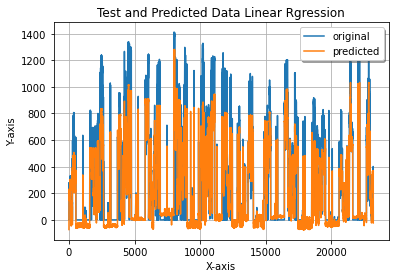

In [10]:
plot_true_vs_pred("Linear Rgression", lr_testing_data_y, lr1_preds)

## Linear Regression 2

In [11]:
ridge_parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

lr2_ridge = GridSearchCV(Ridge(), ridge_parameters, return_train_score=True, scoring='neg_mean_squared_error', n_jobs=-1)
lr2_ridge.fit(lr_training_data_x, lr_training_data_y)

print("Linear Regression Ridge Parameters", lr2_ridge.best_params_)

Linear Regression Ridge Parameters {'alpha': 100}


In [12]:
lr2_preds = lr2_ridge.predict(lr_testing_data_x)
calculate_metrics("Linear Regression Ridge", lr_testing_data_y, lr2_preds)

Linear Regression Ridge MAE: 78.38779111132911 kW.
Linear Regression Ridge RMSE: 140.97396692374963 kW.


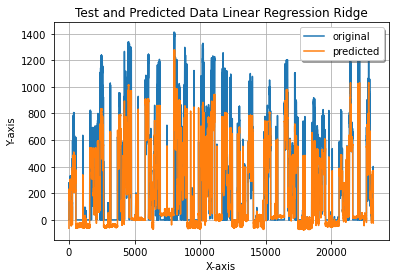

In [13]:
plot_true_vs_pred("Linear Regression Ridge", lr_testing_data_y, lr2_preds)

## Linear Regression 3 Lasso

In [14]:
lr_3 = GridSearchCV(Lasso(), ridge_parameters, return_train_score=True, scoring='neg_mean_squared_error', n_jobs=-1)
lr_3.fit(lr_training_data_x, lr_training_data_y)

print("Linear Rgression Lasso Parameters", lr_3.best_params_)

Linear Rgression Lasso Parameters {'alpha': 0.1}


In [15]:
lr3_preds = lr_3.predict(lr_testing_data_x)
calculate_metrics("Linear Regression Lasso", lr_testing_data_y, lr3_preds)

Linear Regression Lasso MAE: 78.51481343851397 kW.
Linear Regression Lasso RMSE: 141.0821573530057 kW.


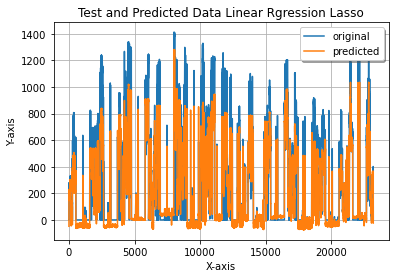

In [16]:
plot_true_vs_pred("Linear Rgression Lasso", lr_testing_data_y, lr3_preds)

## Decision Tree 1

In [17]:
tree_features = ["PLANT_ID", "TIME", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE","IRRADIATION", "is_daytime", "yesterday_max_daily_yield", "yesterday_plant_temperature"]

tree_train_x = train_df[tree_features]
tree_train_y = train_df.AC_POWER

#tree_train_x = train_sunlight[tree_features]
#tree_train_y = train_sunlight.AC_POWER

tree_train_x.PLANT_ID = tree_train_x.PLANT_ID.astype("category")
tree_train_x.is_daytime = tree_train_x.is_daytime.astype("category")
tree_train_x.TIME = tree_train_x.TIME.astype("category")
tree_train_x = pd.get_dummies(tree_train_x)

tree_test_x = test_df[tree_features]
tree_test_y = test_df.AC_POWER

#tree_test_x = test_sunlight[tree_features]
#tree_test_y = test_sunlight.AC_POWER

tree_test_x.PLANT_ID = tree_test_x.PLANT_ID.astype("category")
tree_test_x.is_daytime = tree_test_x.is_daytime.astype("category")
tree_test_x.TIME = tree_test_x.TIME.astype("category")
tree_test_x = pd.get_dummies(tree_test_x)


/Users/nicholasbrathwaite/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [18]:
dt_1_parameters = {'max_depth': range(1,50)}
dt_model = GridSearchCV(DecisionTreeRegressor(random_state = 70),
                       dt_1_parameters,
                       return_train_score = True,
                       verbose=3,
                       scoring='neg_mean_squared_error',
                       n_jobs=-1)

dt_model.fit(tree_train_x, tree_train_y)
print("Optimal Tree Parameters", dt_model.best_params_)

Fitting 5 folds for each of 49 candidates, totalling 245 fits
Optimal Tree Parameters {'max_depth': 6}


In [19]:
dt_preds = dt_model.predict(tree_test_x)
calculate_metrics("Tree Regression", tree_test_y, dt_preds)

Tree Regression MAE: 42.187983066561074 kW.
Tree Regression RMSE: 122.15016872003142 kW.


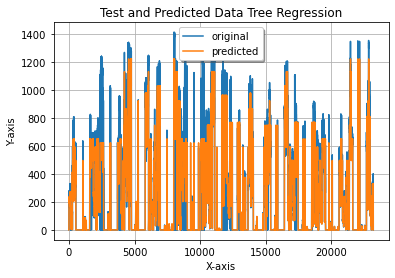

In [20]:
plot_true_vs_pred("Tree Regression", tree_test_y, dt_preds)

In [21]:
feature_importance = pd.Series(dt_model.best_estimator_.feature_importances_,
                              index=tree_train_x.columns)
print("Feature Importance")
feature_importance.sort_values(ascending=False)[0:27]

Feature Importance


IRRADIATION                    0.954172
PLANT_ID_4135001               0.027468
yesterday_max_daily_yield      0.014099
yesterday_plant_temperature    0.002341
AMBIENT_TEMPERATURE            0.001136
MODULE_TEMPERATURE             0.000208
TIME_14:00:00                  0.000195
TIME_07:45:00                  0.000100
TIME_16:30:00                  0.000091
TIME_08:00:00                  0.000072
TIME_13:45:00                  0.000039
TIME_07:30:00                  0.000029
TIME_07:15:00                  0.000029
TIME_07:00:00                  0.000011
TIME_08:15:00                  0.000009
TIME_17:00:00                  0.000000
TIME_16:15:00                  0.000000
TIME_17:15:00                  0.000000
TIME_16:45:00                  0.000000
TIME_15:15:00                  0.000000
TIME_16:00:00                  0.000000
TIME_15:45:00                  0.000000
TIME_15:30:00                  0.000000
TIME_17:45:00                  0.000000
TIME_15:00:00                  0.000000


## Random Forest Trees

In [22]:
rf_params = {'max_depth': np.arange(1,30,1), 'n_estimators': np.arange(1,30,1)}

rfcv = GridSearchCV(RandomForestRegressor(), rf_params, return_train_score=True, scoring = 'neg_mean_squared_error',
                   verbose=2, n_jobs=-1)

start = time.time()
rfcv.fit(tree_train_x, tree_train_y)
stop = time.time()

print(str((stop - start)/60) + "minutes train random forest.")
print("Random Forest Regression:")
print("Optimal Parameters:", rfcv.best_params_)
print("Optimal test R2:", rfcv.best_score_.round(3))

Fitting 5 folds for each of 841 candidates, totalling 4205 fits
29.781902384757995minutes train random forest.
Random Forest Regression:
Optimal Parameters: {'max_depth': 6, 'n_estimators': 22}
Optimal test R2: -25167.682


In [23]:
rf_preds = rfcv.predict(tree_test_x)
calculate_metrics("Random Forest", tree_test_y, rf_preds)

Random Forest MAE: 42.121996864978875 kW.
Random Forest RMSE: 122.60633275473491 kW.


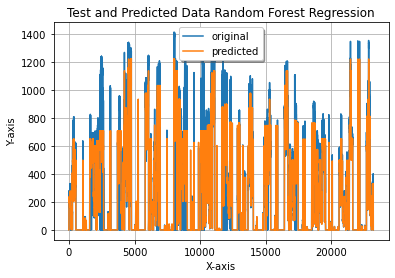

In [24]:
plot_true_vs_pred("Random Forest Regression", tree_test_y, rf_preds)

## Gradient Boosted Trees

In [31]:
gb_params ={'max_depth':np.arange(1,20,1), 'n_estimators': np.arange(1,20,1)}

gb_trees = GridSearchCV(GradientBoostingRegressor(learning_rate = 0.70, random_state=1), gb_params,
                       return_train_score = True,
                       scoring = 'neg_mean_squared_error',
                       verbose=1,
                       n_jobs=-1)

start = time.time()
gb_trees.fit(tree_train_x, tree_train_y)
stop = time.time()

print(str((stop - start)/60) + "minutes train random forest.")
print("Gradient Boosted Tree Regression:")
print("Optimal Parameters:", gb_trees.best_params_)
print("Optimal test R2:", gb_trees.best_score_.round(3))

Fitting 5 folds for each of 361 candidates, totalling 1805 fits
16.12681003808975minutes train random forest.
Gradient Boosted Tree Regression:
Optimal Parameters: {'max_depth': 5, 'n_estimators': 3}
Optimal test R2: -26102.454


In [29]:
gb_preds = gb_trees.predict(tree_test_x)
calculate_metrics("Gradient Boosted Trees", tree_test_y, gb_preds)

Gradient Boosted Trees MAE: 49.06790711987043 kW.
Gradient Boosted Trees RMSE: 122.11847232672794 kW.


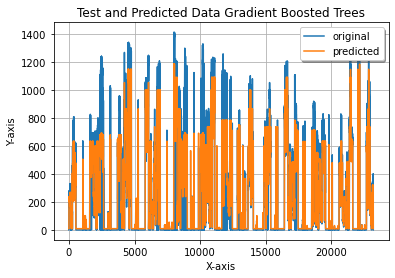

In [30]:
plot_true_vs_pred("Gradient Boosted Trees", tree_test_y, gb_preds)

---